# Project: Wrangle and Investigate WeRateDogs Twitter Archive data

## Table of Contents

- <a href="#intro">Introduction</a>
- <a href="#wrangling">Data Wrangling</a>
    - <a href="#gather">Data Gathering</a>
    - <a href="#assess">Data Assessing</a>
    - <a href="#clean">Data Cleaning</a>
- <a href="#eda">Exploratory Data Analysis</a>
- <a href="#conclusions">Conclusions</a>


<a id='intro'></a>
## Introduction

The dataset to be wrangled( and analyzed and visualized) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs), which is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc.

**Investigations  on,**
> - Which is a super-wow dog breed?
> - What are the factors impacting Retweet and Favorite count?

To perform above investigation, the following questions were set:
<ul>
<li><a href="#rq1">What are the top 30 most tweeted dog breeds by WeRateDogs?</a></li>
<li><a href="#rq2">Which breed of dogs got the highest rating on average?</a></li>
<li><a href="#rq3">Which breed of dogs got the highest retweet and favorite counts on average?</a></li>
<li><a href="#rq4">Which stage of dogs got the highest rating, retweet and favorite counts?</a></li>
<li><a href="#rq5">Does the hashtags included impact retweet and favorite counts?</a></li>
<li><a href="#rq6">How does retweet and favorite counts spread based on the tweeted day of the week on average ?</a></li>
<li><a href="#rq7">Does the rating impact Retweet and Favorite Count?</a></li>
<li><a href="#rq8">Relationship between Retweet and Favorite Count</a></li>
</ul>

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import re
import requests
import json
import tweepy
import string
import datetime as dt
from tweepy import OAuthHandler
from timeit import default_timer as timer

<a id='wrangling'></a>
## Data Wrangling

<a id='gather'></a>
### Data Gathering
> - Download the [Enhanced Twitter Archive data](https://video.udacity-data.com/topher/2018/November/5bf60fbf_twitter-archive-enhanced/twitter-archive-enhanced.csv), `twitter_archive_enhanced.csv` provided by Udacity, which contains basic tweet information
> - Download the [Image Predictions File](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv), containing the predicted breeds of dogs given by Udacity programmatically
> - Twitter API to gather retweet count and favorite count, which are notable columns additionally details of hashtags used

#### 1. Enhanced Twitter Archive data

In [2]:
# Request tsv file from the url
url = "https://video.udacity-data.com/topher/2018/November/5bf60fbf_twitter-archive-enhanced/twitter-archive-enhanced.csv"
response = requests.get(url)

# Write the response into tsv file
with open('data/twitter_archive_enhanced.csv', mode='wb') as file:
    file.write(response.content)
    
# Load data from twitter_archive_enhanced.csv into the dataframe
archive = pd.read_csv('data/twitter_archive_enhanced.csv')

#### 2. Download the Image predictions file

In [3]:
# Request tsv file from the url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# Write the response into tsv file
with open('data/image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
# Load data from the file into DataFrame 
img_pred = pd.read_csv('data/image_predictions.tsv', sep='\t')

#### 3. Gather data (Retweet count, Favorite count & hastags) from Twitter API

**Note :** takes 20-30 minutes to run because of Twitter's rate limit

In [51]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
retweet_favorite_count = []
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            hashtag = tweet._json['entities']['hashtags']
            if hashtag:
                retweet_favorite_count.append({
                "tweet_id" : str(tweet_id),
                "retweet_count" : tweet._json['retweet_count'],
                "favorite_count" : tweet._json['favorite_count'],
                "hashtag" : hashtag[0]['text']
                })
            else:
                retweet_favorite_count.append({
                "tweet_id" : str(tweet_id),
                "retweet_count" : tweet._json['retweet_count'],
                "favorite_count" : tweet._json['favorite_count'],
                "hashtag" : 'None'
                })                            
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()

# storing the retweet_favorite_count into csv file for future assessing data, as this loop takes time
retweet_favorite_count_df = pd.DataFrame(retweet_favorite_count)
retweet_favorite_count_df.to_csv('data/retweet_favorite_count.csv',encoding='utf-8', index=False)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Rate limit reached. Sleeping for: 489


Success
1075: 739844404073074688
Success
1076: 739623569819336705
Success
1077: 739606147276148736
Success
1078: 739544079319588864
Success
1079: 739485634323156992
Success
1080: 739238157791694849
Success
1081: 738891149612572673
Success
1082: 738885046782832640
Success
1083: 738883359779196928
Success
1084: 738537504001953792
Success
1085: 738402415918125056
Success
1086: 738184450748633089
Success
1087: 738166403467907072
Success
1088: 738156290900254721
Success
1089: 737826014890496000
Success
1090: 737800304142471168
Success
1091: 737678689543020544
Success
1092: 737445876994609152
Success
1093: 737322739594330112
Success
1094: 737310737551491075
Success
1095: 736736130620620800
Success
1096: 736392552031657984
Success
1097: 736365877722001409
Success
1098: 736225175608430592
Success
1099: 736010884653420544
Success
1100: 735991953473572864
Success
1101: 735648611367784448
Success
1102: 735635087207878657
Success
1103: 735274964362878976
Success
1104: 735256018284875776
Success
11

Success
1324: 706265994973601792
Success
1325: 706169069255446529
Success
1326: 706166467411222528
Success
1327: 706153300320784384
Success
1328: 705975130514706432
Success
1329: 705970349788291072
Success
1330: 705898680587526145
Success
1331: 705786532653883392
Success
1332: 705591895322394625
Success
1333: 705475953783398401
Success
1334: 705442520700944385
Success
1335: 705428427625635840
Success
1336: 705239209544720384
Success
1337: 705223444686888960
Success
1338: 705102439679201280
Success
1339: 705066031337840642
Success
1340: 704871453724954624
Success
1341: 704859558691414016
Success
1342: 704847917308362754
Success
1343: 704819833553219584
Success
1344: 704761120771465216
Success
1345: 704499785726889984
Success
1346: 704491224099647488
Success
1347: 704480331685040129
Success
1348: 704364645503647744
Success
1349: 704347321748819968
Success
1350: 704134088924532736
Success
1351: 704113298707505153
Success
1352: 704054845121142784
Success
1353: 703774238772166656
Success
13

Success
1573: 687664829264453632
Success
1574: 687494652870668288
Success
1575: 687480748861947905
Success
1576: 687476254459715584
Success
1577: 687460506001633280
Success
1578: 687399393394311168
Success
1579: 687317306314240000
Success
1580: 687312378585812992
Success
1581: 687127927494963200
Success
1582: 687124485711986689
Success
1583: 687109925361856513
Success
1584: 687102708889812993
Success
1585: 687096057537363968
Success
1586: 686947101016735744
Success
1587: 686760001961103360
Success
1588: 686749460672679938
Success
1589: 686730991906516992
Success
1590: 686683045143953408
Success
1591: 686618349602762752
Success
1592: 686606069955735556
Success
1593: 686394059078897668
Success
1594: 686386521809772549
Success
1595: 686377065986265092
Success
1596: 686358356425093120
Success
1597: 686286779679375361
Success
1598: 686050296934563840
Success
1599: 686035780142297088
Success
1600: 686034024800862208
Success
1601: 686007916130873345
Success
1602: 686003207160610816
Success
16

Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
1832: 676215927814406144
Success
1833: 676191832485810177
Success
1834: 676146341966438401
Success
1835: 676121918416756736
Success
1836: 676101918813499392
Success
1837: 676098748976615425
Success
1838: 676089483918516224
Success
1839: 675898130735476737
Success
1840: 675891555769696257
Success
1841: 675888385639251968
Success
1842: 675878199931371520
Success
1843: 675870721063669760
Success
1844: 675853064436391936
Success
1845: 675849018447167488
Success
1846: 675845657354215424
Success
1847: 675822767435051008
Success
1848: 675820929667219457
Success
1849: 675798442703122432
Success
1850: 675781562965868544
Success
1851: 675740360753160193
Success
18

Rate limit reached. Sleeping for: 496


Success
1975: 673148804208660480
Success
1976: 672997845381865473
Success
1977: 672995267319328768
Success
1978: 672988786805112832
Success
1979: 672984142909456390
Success
1980: 672980819271634944
Success
1981: 672975131468300288
Success
1982: 672970152493887488
Success
1983: 672968025906282496
Success
1984: 672964561327235073
Success
1985: 672902681409806336
Success
1986: 672898206762672129
Success
1987: 672884426393653248
Success
1988: 672877615439593473
Success
1989: 672834301050937345
Success
1990: 672828477930868736
Success
1991: 672640509974827008
Success
1992: 672622327801233409
Success
1993: 672614745925664768
Success
1994: 672609152938721280
Success
1995: 672604026190569472
Success
1996: 672594978741354496
Success
1997: 672591762242805761
Success
1998: 672591271085670400
Success
1999: 672538107540070400
Success
2000: 672523490734551040
Success
2001: 672488522314567680
Success
2002: 672482722825261057
Success
2003: 672481316919734272
Success
2004: 672475084225949696
Success
20

Success
2224: 668297328638447616
Success
2225: 668291999406125056
Success
2226: 668286279830867968
Success
2227: 668274247790391296
Success
2228: 668268907921326080
Success
2229: 668256321989451776
Success
2230: 668248472370458624
Success
2231: 668237644992782336
Success
2232: 668226093875376128
Success
2233: 668221241640230912
Success
2234: 668204964695683073
Success
2235: 668190681446379520
Success
2236: 668171859951755264
Success
2237: 668154635664932864
Success
2238: 668142349051129856
Success
2239: 668113020489474048
Success
2240: 667937095915278337
Success
2241: 667924896115245057
Success
2242: 667915453470232577
Success
2243: 667911425562669056
Success
2244: 667902449697558528
Success
2245: 667886921285246976
Success
2246: 667885044254572545
Success
2247: 667878741721415682
Success
2248: 667873844930215936
Success
2249: 667866724293877760
Success
2250: 667861340749471744
Success
2251: 667832474953625600
Success
2252: 667806454573760512
Success
2253: 667801013445750784
Success
22

In [52]:
# Check the error messages for the fail status
print(end - start)
fails_dict

2067.8954828


{888202515573088257: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 873697596434513921: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 872668790621863937: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 872261713294495745: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 869988702071779329: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 866816280283807744: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 861769973181624320: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 856602993587888130: tweepy.error.TweepError([{'code': 144,
  

> **Note:** As the error type  is either `No status found with that ID` or `Authorization issue`, let's move on with the data we have as success state

In [4]:
# Load data from the file into DataFrame 
retweet_favorite_count = pd.read_csv('data/retweet_favorite_count.csv', encoding='utf-8')

<a id='assess'></a>
### Data Assessing
> **Types of assessment:**
> - <a href='#visual'>Visual</a>
> - <a href='#prog'>Programmatic</a>

<a id='visual'></a>
### Visual assessment

In [5]:
# archive data
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [6]:
# Image predictions data
img_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [7]:
# Twitter API - retweet_favorite_count data
retweet_favorite_count

,tweet_id,retweet_count,favorite_count,hashtag
0,892420643555336193,7317,34846,None
1,892177421306343426,5466,30190,None
2,891815181378084864,3607,22727,None
3,891689557279858688,7498,38099,None
4,891327558926688256,8060,36372,BarkWeek
...,...,...,...,...
2326,666049248165822465,38,92,None
2327,666044226329800704,121,257,None
2328,666033412701032449,39,105,None
2329,666029285002620928,41,117,None


**On further visual assessment in Excel,**
> **archive :**
    > - Surprising values in `rating_denominator` & `rating_numerator` column
    > - Inaccurate values in `name` column : a, an, all, the
    > - Observations for Retweet and Reply is present : those with values in (`retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) and (`in_reply_to_status_id`, `in_reply_to_user_id`) respectively
    > - Each category in Stages of dog as separate column : `doggo`, `floofer`, `pupper`, `puppo`  
    
> **img_pred :**
    > - Some breed name starts with Upper case, others with lower case (p1,p2,p3)
    > - Underscore '_' present instead of space in dog breeds (p1,p2,p3)
    > - One Prediction data with `TRUE` and `higher confidence` is enough among the top three predictions

<a id='prog'></a>
### Programmatic assessment
> - <a href='#archive'>archive</a>
> - <a href='#img_pred'>img_pred</a>
> - <a href='#retweet_favorite_count'>retweet_favorite_count</a>

<a id='archive'></a>
#### 1. archive

In [8]:
# Inspect data types and missing/possibly errant data
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
# Datatype of timestamp
print('timestamp :', type(archive.timestamp[0]))

timestamp : <class 'str'>


> **Note :** Only original ratings (no retweets) that have images are considered. Therefore, related columns are avoided in the analysis
> - Observations for Reply : 78
> - Observations for Retweet : 181

> - `tweet_id` datatype int64 instead of string
> - `timestamp` datatype str instead of timestamp
> - `expanded_urls` has null values

In [10]:
# Perform operations to inspect number of uniques values in each column
archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [11]:
# describe
archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [12]:
# Unique values in rating_numerator
archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [13]:
# Unique values in rating_denominator
archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [14]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",280)

# Check the text columns for the observations where numeration is so high or denominator != 10
# exclude retweet and reply
archive_assess = archive[((archive['rating_numerator'] > 14) | (archive['rating_denominator'] != 10)) & (archive.in_reply_to_status_id.isnull() & archive.retweeted_status_id.isnull())]
archive_assess[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


> - some ratings are inaccurate based on text
> - some other high values are are due to tweeter has given ratings to group of dogs present in the post. Sample: [one of the video from our data](https://t.co/HmwrdfEfUE) and [image](https://t.co/ZanVtAtvIq)
> - Inconsistent rating, but the rating numerators are greater than the denominators does not need to be cleaned (as per project requirement). This [unique rating system](https://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.

In [15]:
# Look for instances of duplicates
archive.duplicated().value_counts()

False    2356
dtype: int64

In [16]:
# Unique values in name
archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

> - Doubtful names : a, an, all, the, mad, his, such, quite, not, one (the names starting with lower case are not the real names)

In [17]:
# Unique value and counts of source
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

> - Complete tag present instead of source name

In [18]:
# Unique value and counts of doggo
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [19]:
# Unique value and counts of floofer
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [20]:
# Unique value and counts of pupper
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [21]:
# Unique value and counts of puppo
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [22]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",250)

# content in text and expanded_urls
archive[['text','expanded_urls']].head()

,text,expanded_urls
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


In [23]:
# Check content in text for expanded_urls=null 
# exclude retweet and reply
archive[archive.expanded_urls.isnull() & archive.in_reply_to_status_id.isnull() & archive.retweeted_status_id.isnull()][['text','expanded_urls']]

,text,expanded_urls
375,Beebop and Doobert should start a band 12/10 would listen,NaN
707,"Today, 10/10, should be National Dog Rates Day",NaN
1445,Oh my god 10/10 for every little hot dog pupper,NaN


> - `text` have both text in tweet and url for the tweet
> - `expanded_urls` have url for the tweet, sometimes more than on value separated by comma (,)
> - three observations don't have url to the tweet

<a id='img_pred'></a>
#### 2. img_pred

In [24]:
# Inspect data types and missing/possibly errant data
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> - `tweet_id` datatype int64 instead of string

In [25]:
# describe
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
# Look for instances of duplicates
img_pred.duplicated().value_counts()

False    2075
dtype: int64

<a id='retweet_favorite_count'></a>
#### 3. retweet_favorite_count

In [27]:
# Inspect data types and missing/possibly errant data
retweet_favorite_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   int64 
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
 3   hashtag         2331 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.0+ KB


> - `tweet_id` datatype int64 instead of string

In [28]:
# describe
retweet_favorite_count[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2573.803947,7276.694123
std,4353.346536,11302.114569
min,1.000000,0.000000
25%,522.500000,1259.500000
50%,1200.000000,3152.000000
75%,2979.500000,8893.000000
max,73840.000000,149683.000000


In [29]:
# Unique values and counts in hashtag
retweet_favorite_count.hashtag.value_counts()

None                     2304
BarkWeek                    9
PrideMonth                  3
WomensMarch                 1
PrideMonthPuppo             1
K9VeteransDay               1
BellLetsTalk                1
ScienceMarch                1
LoveTwitter                 1
WKCDogShow                  1
NoDaysOff                   1
Canada150                   1
FinalFur                    1
notallpuppers               1
dogsatpollingstations       1
GoodDogs                    1
ImWithThor                  1
BATP                        1
Name: hashtag, dtype: int64

In [30]:
# Duplicate column names 
all_columns = pd.Series(list(archive) + list(img_pred) + list(retweet_favorite_count))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

### Observations based on Assessing the dataset :
### Quality issues

#####  `archive` table
- <a href='#1'>(1)</a> **Note :** Only original ratings (no retweets) that have images are considered. Observations for Retweet and Reply is present : those with values in (`retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) and (`in_reply_to_status_id`, `in_reply_to_user_id`) respectively to be avoided,
> - Observations for Reply : 78
> - Observations for Retweet : 181
- <a href='#2'>(2)</a> Uninterested columns : `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id`
- <a href='#3'>(3)</a> Erroneous datatypes : `tweet_id` and `timestamp`
- <a href='#4'>(4)</a> Surprising values in `rating_denominator` & `rating_numerator` column
> - some ratings are inaccurate based on text
> - some other high values is true and are due to tweeter has given ratings to group of dogs present in the post. Sample : [one of the video from our data](https://t.co/HmwrdfEfUE) and [image](https://t.co/ZanVtAtvIq)
- <a href='#7'>(7)</a> Doubtful names : a, an, all, the, mad, his, such, quite, not, one (the names starting with lower case are not the real names)
- <a href='#9'>(9)</a> The html ampersand code "&amp" in the `text` column
- <a href='#9'>(9)</a> "/n" the newline symbol in the `text` column
- <a href='#10'>(10)</a> Each category in Stages of dog as separate column : `doggo`, `floofer`, `pupper`, `puppo` 
- <a href='#11'>(11)</a> `expanded_urls` (url for the tweet) has three null values
- <a href='#11'>(11)</a> `expanded_urls` sometimes have more than one value separated by comma (,)
- <a href='#13'>(13)</a> Inconsistent rating, but the rating numerators are greater than the denominators does not need to be cleaned (as per project requirement). This [unique rating system](https://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.

#####  `img_pred` table
- <a href='#3'>(3)</a> Erroneous datatype : `tweet_id`
- <a href='#5'>(5)</a> One Prediction data with `TRUE` and `higher confidence` is enough among the top three predictions
- <a href='#12'>(12)</a> Some breed name starts with Upper case, others with lower case (p1,p2,p3)
- <a href='#12'>(12)</a> Underscore '_' present instead of space in dog breeds (p1,p2,p3)
- <a href='#12'>(12)</a> Few names with '-' present

#####  `retweet_favorite_count` table
- <a href='#3'>(3)</a> Erroneous datatype : `tweet_id`

### Tidiness issues

#####  `archive` table
- <a href='#8'>(8)</a> Complete tag present instead of source name in `source`
- <a href='#9'>(9)</a> `text` have both text in tweet and url for the tweet

#### Common
- <a href='#6'>(6)</a> Duplicate column names present in `archive`, `img_pred` and `retweet_favorite_count`
- <a href='#6'>(6)</a> Total observations in `archive` (2356) is more than `img_pred` (2075) and `retweet_favorite_count` (2331 - as some tweet ID status is not available now)


<a id='clean'></a>
### Data Cleaning

In [31]:
# Make a copy of three dataframes
archive_copy = archive.copy()
img_pred_copy = img_pred.copy()
ret_fav_hash_copy = retweet_favorite_count.copy()

<a id='1'></a>
### Issue 1
#### Define : 
Drop observations in `archive_copy` for reply and retweet, by deleting the rows with values present in `in_reply_to_status_id` and `retweeted_status_id`
#### Clean :

In [32]:
# Get the index of the observations of reply
index_reply = archive_copy[archive_copy.in_reply_to_status_id.isnull() == False].index

In [33]:
# Get the index of the observations of retweet
index_retweet = archive_copy[archive_copy.retweeted_status_id.isnull() == False].index

In [34]:
# all index
index = set(index_reply.append(index_retweet))
# total number of observations
len(index)

259

In [35]:
# Drop the rows from the DataFrame
archive_copy.drop(index, inplace=True)

In [36]:
# Reset index after drop
archive_copy.reset_index(drop=True, inplace=True)

#### Test :

In [37]:
# Check whether the reply observations are dropped from DataFrame
assert archive_copy.in_reply_to_status_id.isnull().all() == True

In [38]:
# Check whether the retweet observations are dropped from DataFrame
assert archive_copy.retweeted_status_id.isnull().all() == True

In [39]:
# Rows after drop
archive_copy.shape[0]

2097

<a id='2'></a>
### Issue 2
#### Define :
Drop uninterested columns in `archive_copy` dataframe : `retweeted_status_id` , `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id`
#### Clean :

In [40]:
columns_to_drop = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
           'in_reply_to_status_id', 'in_reply_to_user_id']

In [41]:
# Drop reply  and retweet columns columns
archive_copy.drop(columns_to_drop, axis = 1, inplace=True)

#### Test : 

In [42]:
# Check if columns are dropped
assert archive_copy.columns.any() not in columns_to_drop

In [43]:
# columns names
archive_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

<a id='3'></a>
### Issue 3
#### Define :
- Convert the Erroneous datatype in `archive_copy`
    - `timestamp` : string to timestamp

- Convert the Erroneous datatypes in `archive_copy`, `img_pred_copy` and `ret_fav_hash_copy`
    -  `tweet_id` : int to string
    
#### Clean :    

In [44]:
# Convert datatype of timestamp column to timestamp
archive_copy.timestamp = pd.to_datetime(archive_copy.timestamp)

In [45]:
# Convert datatype of tweet_id in archive_copy, img_pred_copy and ret_fav_hash_copy
archive_copy.tweet_id = archive_copy.tweet_id.astype(str)
img_pred_copy.tweet_id = img_pred_copy.tweet_id.astype(str)
ret_fav_hash_copy.tweet_id = ret_fav_hash_copy.tweet_id.astype(str)

#### Test :

In [46]:
# check if datatype timestamp column is timestamp
assert type(archive_copy.timestamp[0]) is pd.Timestamp

In [47]:
# check if tweet_id is str in archive_copy
assert type(archive_copy.tweet_id[0]) is str

In [48]:
# check if tweet_id is str in img_pred_copy
assert type(img_pred_copy.tweet_id[0]) is str

In [49]:
# check if tweet_id is str in ret_fav_hash_copy
assert type(ret_fav_hash_copy.tweet_id[0]) is str

<a id='4'></a>
### Issue 4
#### Define :
Change the surprising(inaccurate) values in `rating_denominator` & `rating_numerator` column based on text in `archive_copy`

#### Clean :

In [50]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",280)

In [51]:
# Check the text columns for the observations where numerator is so high (usual < 13) or denominator != 10
archive_assess = archive_copy[((archive_copy['rating_numerator'] > 13) | (archive_copy['rating_denominator'] != 10))]
archive_assess[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
9,890240255349198849,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14,10
21,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,14,10
32,885518971528720385,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,14,10
37,884441805382717440,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",14,10
51,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,14,10
67,878057613040115712,This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,14,10
73,876537666061221889,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,14,10
95,871102520638267392,Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,14,10
101,870063196459192321,Meet Clifford. He's quite large. Also red. Good w kids. Somehow never steps on them. Massive poops very inconvenient. Still 14/10 would ride https://t.co/apVOyDgOju,14,10
106,868880397819494401,This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,14,10


In [52]:
# Change the surprising(inaccurate) values in rating_denominator & rating_numerator column based on text in archive_copy

# From the text of tweet id = 810984652412424192, there is no rating, hence assigning 10/10
archive_copy.loc[archive_copy.tweet_id == '810984652412424192', ['rating_numerator', 'rating_denominator']] = [10,10]

# From the text of tweet id = 786709082849828864, the value should be 9.75/10
archive_copy.loc[archive_copy.tweet_id == '786709082849828864', ['rating_numerator', 'rating_denominator']] = [9.75,10]

# From the text of tweet id = 778027034220126208, the value should be 11.27/10
archive_copy.loc[archive_copy.tweet_id == '778027034220126208', ['rating_numerator', 'rating_denominator']] = [11.27,10]

# From the text of tweet id = 740373189193256964, the value should be 14/10
archive_copy.loc[archive_copy.tweet_id == '740373189193256964', ['rating_numerator', 'rating_denominator']] = [14,10]

# From the text of tweet id = 722974582966214656, the value should be 13/10
archive_copy.loc[archive_copy.tweet_id == '722974582966214656', ['rating_numerator', 'rating_denominator']] = [13,10]

# From the text of tweet id = 716439118184652801, the value should be 11/10
archive_copy.loc[archive_copy.tweet_id == '716439118184652801', ['rating_numerator', 'rating_denominator']] = [11,10]

# From the text of tweet id = 682962037429899265, the value should be 10/10
archive_copy.loc[archive_copy.tweet_id == '682962037429899265', ['rating_numerator', 'rating_denominator']] = [10,10]

# From the text of tweet id = 680494726643068929, the value should be 11.26/10
archive_copy.loc[archive_copy.tweet_id == '680494726643068929', ['rating_numerator', 'rating_denominator']] = [11.26,10]

# From the text of tweet id = 666287406224695296, the value should be 9/10
archive_copy.loc[archive_copy.tweet_id == '666287406224695296', ['rating_numerator', 'rating_denominator']] = [9,10]

> - some other high values is true and are due to tweeter has given ratings to group of dogs present in the post 
> - sample : [one of the video from our data](https://t.co/HmwrdfEfUE) and [image](https://t.co/ZanVtAtvIq)

#### Test :

In [53]:
# Check the unique values of rating_numerator
archive_copy.rating_numerator.value_counts()

12.00      486
10.00      438
11.00      414
13.00      288
9.00       153
8.00        98
7.00        51
14.00       39
5.00        34
6.00        32
3.00        19
4.00        15
2.00         9
1.00         4
88.00        1
84.00        1
420.00       1
165.00       1
60.00        1
0.00         1
99.00        1
1776.00      1
11.27        1
44.00        1
144.00       1
121.00       1
11.26        1
204.00       1
9.75         1
45.00        1
80.00        1
Name: rating_numerator, dtype: int64

In [54]:
# Check the unique values of rating_denominator
archive_copy.rating_denominator.value_counts()

10     2086
50        2
80        2
40        1
70        1
90        1
110       1
120       1
150       1
170       1
Name: rating_denominator, dtype: int64

<a id='5'></a>
### Issue 5
#### Define :
One Prediction data with `TRUE` and `higher confidence` is enough among the top three predictions in `img_pred_copy`
- Drop the remaining column and uninterested columns

#### Clean :  

In [55]:
# The confidence value is already in sorted order, p1_conf > p2_conf > p3_conf

# create empty lists to save our choice for each row in the dataset
breed = []
confidence = []

# function that iterates through prediction columns to find the best prediction which is a breed of dog.
def breed_confidence(row):
    if row.p1_dog == True:
        breed.append(row.p1)
        confidence.append(row.p1_conf)
    elif row.p2_dog == True:
        breed.append(row.p2)
        confidence.append(row.p2_conf)
    elif row.p3_dog == True:
        breed.append(row.p3)
        confidence.append(row.p3_conf)
    else:
        breed.append('Unpredicted')
        confidence.append(0)
        
# call function using pandas apply by columns
img_pred_copy.apply(breed_confidence, axis=1)

# add lists created to master dataframe
img_pred_copy['breed'] = breed
img_pred_copy['confidence'] = confidence   

In [56]:
columns_to_drop = ['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

# Drop the uninterested columns
img_pred_copy.drop(columns = ['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### Test :

In [57]:
# Check if unwanted columns dropped
assert img_pred_copy.columns.any() not in columns_to_drop

In [58]:
# Check if the breed and confidence values are filled in
img_pred_copy

,tweet_id,jpg_url,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581


<a id='6'></a>
### Issue 6
#### Define :
**Remove Duplicate column** names and **select common tweet data rows** present in `archive_copy`, `img_pred_copy` and `ret_fav_hash_copy`, by merging the dataframes into single master dataframe
#### Clean :   

In [59]:
# Merge archive_copy and ret_fav_hash_copy
df = pd.merge(archive_copy, ret_fav_hash_copy, on='tweet_id')

In [60]:
# Merge df and img_pred_copy
df = pd.merge(df, img_pred_copy, on='tweet_id')

#### Test :

In [61]:
# number of tweets after merging
df.shape[0]

1964

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   object             
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   source              1964 non-null   object             
 3   text                1964 non-null   object             
 4   expanded_urls       1964 non-null   object             
 5   rating_numerator    1964 non-null   float64            
 6   rating_denominator  1964 non-null   int64              
 7   name                1964 non-null   object             
 8   doggo               1964 non-null   object             
 9   floofer             1964 non-null   object             
 10  pupper              1964 non-null   object             
 11  puppo               1964 non-null   object             
 12  retweet_count       1964 non-null 

**Note :** After joining based on currently available data (present status of tweet), we have **1964** tweet data

<a id='7'></a>
### Issue 7
#### Define :
Replace Doubtful names : a, an, all, the, mad, his, such, quite, not, one (the names starting with lower case are not the real names) with None
#### Clean :  

In [63]:
# Replace Doubtful names : a, an, all, the, mad, his, such, quite, not, one 
# (the names starting with lower case are not the real names) with None
df.name = df.name.apply(lambda x : 'None' if x[0].islower() else x)

### Test :

In [64]:
# Check the lowercase names are removed
assert df.name.apply(lambda x : x[0].isupper()).all()

<a id='8'></a>
### Issue 8
#### Define :
Replace with **source name** instead of tag using regex

#### Clean :

In [65]:
# Unique values and counts of source before replace
df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1926
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [66]:
# replace the tags with actual source using regex
df.source = df.source.apply(lambda x : re.findall('[A-Z][a-zA-Z\s]*', x)[0])

#### Test :

In [67]:
# # Unique values and counts of source after replace
df.source.value_counts()

Twitter for iPhone    1926
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

<a id='9'></a>
### Issue 9
#### Define
- Remove url for the tweet from the `text` column, as the url is already present in `expanded_urls` column using regex
- Convert the html ampersand code from "&amp ;" to "&" in the text column
- Replace the "/n" the newline symbol with " "

#### Clean :

In [68]:
# text before removing url
df[['tweet_id','text']].sample(5)

,tweet_id,text
132,859607811541651456,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0
1359,680176173301628928,This pupper is patiently waiting to scare the shit out of Santa. 10/10 https://t.co/NhXo67K6yt
1418,677662372920729601,"In honor of the new Star Wars movie. Here's Yoda pug. 12/10 pet really well, would I https://t.co/pvjdRn00XH"
957,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
29,886258384151887873,This is Waffles. His doggles are pupside down. Unsure how to fix. 13/10 someone assist Waffles https://t.co/xZDA9Qsq1O


In [69]:
# replace the url with empty "" using regex
df['text'] = df.text.apply(lambda x : re.sub('http\S+','', x).strip())

# Replace &amp with &
df['text'] = df.text.str.replace("&amp;", "&")

# Replace \n with ' '
df['text'] = df.text.str.replace("\n", " ")

#### Test :

In [70]:
# text after removing url
df[['tweet_id','text']].sample(5)

,tweet_id,text
1026,705239209544720384,This is Jimothy. He lost his body during the the Third Crusade (tragic). 11/10 heroic af tho
481,789530877013393408,This is Rizzy. She smiles a lot. 12/10 contagious af
1237,687127927494963200,Meet Gordon. He's an asshole. 9/10 would still pet
76,874296783580663808,This is Jed. He may be the fanciest pupper in the game right now. Knows it too. 13/10 would sign modeling contract
285,826240494070030336,We only rate dogs. Please don't send in any more non-dogs like this Wild Albanian Street Moose. Thank you... 11/10


In [71]:
# Check if &amp, \n is removed
assert not df.text.str.contains('&amp|\n', regex=True).any()

<a id='10'></a>
### Issue 10
#### Define
- Create a categorical column `stage` for storing different stages of dog which is now in separate column : `doggo`, `floofer`, `pupper`, `puppo`
- Drop `doggo`, `floofer`, `pupper`, `puppo`

#### Clean :

In [72]:
# Check if each row has only one stage, because almost all dogs may be addressed as floofer irrespective of actual dog stage (as per definition)
(df.doggo + df.floofer + df.pupper + df.puppo).value_counts()

NoneNoneNoneNone        1662
NoneNonepupperNone       201
doggoNoneNoneNone         62
NoneNoneNonepuppo         22
doggoNonepupperNone        8
NoneflooferNoneNone        7
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
dtype: int64

> **Note :** Number of rows with more than one stage,
> - `doggo` and `pupper`  : 8
> - `doggo` and `puppo`   : 1
> - `doggo` and `floofer` : 1

> Other than being coupled with floofer, there are two other possibilites being coupled. Manual Check those tweet data

In [73]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",250)

# Manual reading of text of tweet with two stages
df[(df.doggo != 'None') & ((df.pupper != 'None') | (df.puppo != 'None') | (df.floofer != 'None'))][['text','doggo','floofer','pupper','puppo']]

,text,doggo,floofer,pupper,puppo
145,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for,doggo,None,None,puppo
151,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs",doggo,floofer,None,None
333,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",doggo,None,pupper,None
390,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,doggo,None,pupper,None
417,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,doggo,None,pupper,None
502,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,doggo,None,pupper,None
643,"Meet Maggie & Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",doggo,None,pupper,None
694,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,doggo,None,pupper,None
783,This is just downright precious af. 12/10 for both pupper and doggo,doggo,None,pupper,None
829,"Like father (doggo), like son (pupper). Both 12/10",doggo,None,pupper,None


In [74]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",250)
df[(df.doggo != 'None') & ((df.pupper != 'None') | (df.puppo != 'None') | (df.floofer != 'None'))][['tweet_id','expanded_urls','text']]

,tweet_id,expanded_urls,text
145,855851453814013952,https://twitter.com/dog_rates/status/855851453814013952/photo/1,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for
151,854010172552949760,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs"
333,817777686764523521,https://twitter.com/dog_rates/status/817777686764523521/video/1,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)"
390,808106460588765185,https://twitter.com/dog_rates/status/808106460588765185/photo/1,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time
417,801115127852503040,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine
502,785639753186217984,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously
643,759793422261743616,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1","Meet Maggie & Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time"
694,751583847268179968,https://twitter.com/dog_rates/status/751583847268179968/photo/1,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho
783,741067306818797568,https://twitter.com/dog_rates/status/741067306818797568/photo/1,This is just downright precious af. 12/10 for both pupper and doggo
829,733109485275860992,https://twitter.com/dog_rates/status/733109485275860992/photo/1,"Like father (doggo), like son (pupper). Both 12/10"


In [75]:
# From the text and browsing expanded_urls

# tweet_id = 751583847268179968 has dog of stage = doggo, not pupper
df.loc[df.tweet_id == '751583847268179968', 'pupper'] = 'None'

# tweet_id = 785639753186217984 has dog of stage = doggo, not pupper
df.loc[df.tweet_id == '785639753186217984', 'pupper'] = 'None'

# tweet_id = 801115127852503040 has dog of stage = pupper, not doggo
df.loc[df.tweet_id == '801115127852503040', 'doggo'] = 'None'

# tweet_id = 817777686764523521 has dog of stage = pupper, not doggo
df.loc[df.tweet_id == '817777686764523521', 'doggo'] = 'None'

# tweet_id = 855851453814013952 has dog of stage = puppo, not doggo
df.loc[df.tweet_id == '855851453814013952', 'doggo'] = 'None'

# Remaining picture have both stages

In [76]:
# Check the unique values
(df.doggo + df.floofer + df.pupper + df.puppo).value_counts()

NoneNoneNoneNone        1662
NoneNonepupperNone       203
doggoNoneNoneNone         64
NoneNoneNonepuppo         23
NoneflooferNoneNone        7
doggoNonepupperNone        4
doggoflooferNoneNone       1
dtype: int64

In [77]:
# Create stage column
df['stage'] = df.apply(lambda x : re.sub('None,*','',(x.doggo +','+ x.floofer + x.puppo + x.pupper)).rstrip(',') 
                     if re.sub('None','',(x.doggo + x.floofer + x.pupper + x.puppo)) != ''
                     else 'None', axis=1)

In [78]:
# Drop `doggo`, `floofer`, `pupper`, `puppo`
columns_to_drop = ['doggo','floofer','pupper','puppo']
df.drop(columns = columns_to_drop, inplace = True)

#### Test :

In [79]:
# Check if feature is created
assert 'stage' in df.columns

In [80]:
# Check if the columns `doggo`, `floofer`, `pupper`, `puppo` dropped
assert df.columns.any() not in columns_to_drop

In [81]:
# Check the unique values
df.stage.value_counts()

None             1662
pupper            203
doggo              64
puppo              23
floofer             7
doggo,pupper        4
doggo,floofer       1
Name: stage, dtype: int64

<a id='11'></a>
### Issue 11
#### Define
- Get the `expanded_urls` value from Twitter API, if not present
- If more than one url in `expanded_urls` and they are same, remove the others keeping only one url

#### Clean :

In [82]:
# Check if there are any null values
df.expanded_urls.isnull().sum()

0

> **Note :** There are no null after merging the tables

In [83]:
# Check if any row has url more than once
df.expanded_urls.apply(lambda x : len(x.split(','))).value_counts()

1    1462
2     279
3     110
4     105
5       8
Name: expanded_urls, dtype: int64

> **Note :** The count of url in a row ranges from **1** to **5**

In [84]:
# create empty list to append
url = []

# Function to remove the additional url for rows having more than one url, if they are same
def remove_url(row):
    # split the url 
    split_url = row.expanded_urls.split(',')
    # set returns uniques elements
    url_set = set(split_url)
    # Convert set into comma separated string
    url_str = ",".join(url_set)
    # append the url str
    url.append(url_str)
            
        
# call function using pandas apply by columns
df.apply(remove_url, axis=1)

# add lists created to master dataframe
df.expanded_urls = url    

#### Test :

In [85]:
# Check again
df.expanded_urls.apply(lambda x : len(x.split(','))).value_counts()

1    1936
2      28
Name: expanded_urls, dtype: int64

In [86]:
# Manual Checking of those 28 rows
df[df.expanded_urls.apply(lambda x : len(x.split(','))) == 2][['tweet_id','expanded_urls']]

,tweet_id,expanded_urls
6,890971913173991426,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1"
26,886736880519319552,"https://www.gofundme.com/mingusneedsus,https://twitter.com/dog_rates/status/886736880519319552/photo/1"
63,878281511006478336,"https://twitter.com/dog_rates/status/878281511006478336/photo/1,https://www.gofundme.com/3yd6y1c"
80,873213775632977920,"https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://www.gofundme.com/help-my-baby-sierra-get-better"
91,870656317836468226,"https://twitter.com/dog_rates/status/870656317836468226/photo/1,https://www.gofundme.com/help-fix-codys-torn-acl"
101,868552278524837888,"https://www.gofundme.com/3ti3nps,https://twitter.com/dog_rates/status/868552278524837888/photo/1"
118,863062471531167744,"https://www.gofundme.com/helpquinny,https://twitter.com/dog_rates/status/863062471531167744/photo/1"
126,860563773140209665,"https://twitter.com/dog_rates/status/860563773140209665/photo/1,https://www.gofundme.com/help-lorenzo-beat-cancer"
140,857393404942143489,"https://www.gofundme.com/meeko-needs-heart-surgery,https://twitter.com/dog_rates/status/857393404942143489/photo/1"
155,852912242202992640,"https://www.gofundme.com/bennys-medical-bills,https://twitter.com/dog_rates/status/852912242202992640/photo/1"


In [87]:
# Check the datatype
assert type(df.expanded_urls[0]) is str

<a id='12'></a>
### Issue 12
#### Define
- Replace '_' with space in `breed`
- Replace '-' with space/no space for breeds wherever needed based on actual name browsing
- Convert the starting letter in `breed` from  lower case to upper case

#### Clean :

In [88]:
# Replace '_' with empty space
df.breed = df.breed.str.replace('_',' ')

In [89]:
# Capitalize the starting  letters
df.breed = df.breed.apply(lambda x : string.capwords(x))

In [90]:
# Check the names with -
df[df.breed.str.contains('-')].breed.unique()

array(['German Short-haired Pointer', 'Flat-coated Retriever',
       'Black-and-tan Coonhound', 'Soft-coated Wheaten Terrier',
       'Curly-coated Retriever', 'Wire-haired Fox Terrier', 'Shih-tzu'],
      dtype=object)

In [91]:
# 'German Short-haired Pointer' should be 'German Shorthaired Pointer'
# 'Black-and-tan Coonhound' should be 'Black and Tan Coonhound'
# 'Wire-haired Fox Terrier' should be 'Wire Fox Terrier'
# 'Shih-tzu' should be 'Shih Tzu'
conditions = [
    df.breed == 'German Short-haired Pointer',
    df.breed == 'Black-and-tan Coonhound',
    df.breed == 'Wire-haired Fox Terrier',
    df.breed == 'Shih-tzu'
]
choices = [
    'German Shorthaired Pointer',
    'Black and Tan Coonhound',
    'Wire Fox Terrier',
    'Shih Tzu'
]
df.breed = np.select(conditions, choices, default = df.breed )

#### Test :

In [92]:
# Check the names with -
df[df.breed.str.contains('-')].breed.unique()

array(['Flat-coated Retriever', 'Soft-coated Wheaten Terrier',
       'Curly-coated Retriever'], dtype=object)

In [93]:
# Check the unique names
df.breed.unique()

array(['Unpredicted', 'Chihuahua', 'Labrador Retriever', 'Basset',
       'Chesapeake Bay Retriever', 'Appenzeller', 'Pomeranian',
       'Irish Terrier', 'Pembroke', 'Samoyed', 'French Bulldog',
       'Golden Retriever', 'Whippet', 'Siberian Husky',
       'Mexican Hairless', 'Kuvasz', 'Pug', 'Blenheim Spaniel',
       'Malamute', 'Italian Greyhound', 'Chow', 'German Shepherd',
       'Doberman', 'Eskimo Dog', 'Weimaraner', 'Saluki',
       'Miniature Pinscher', 'German Shorthaired Pointer',
       'English Springer', 'Vizsla', 'Bloodhound', 'Bernese Mountain Dog',
       'West Highland White Terrier', 'Cocker Spaniel',
       'Flat-coated Retriever', 'Cardigan', 'Newfoundland',
       'Shetland Sheepdog', 'Komondor', 'Kelpie',
       'Greater Swiss Mountain Dog', 'Border Collie', 'Bull Mastiff',
       'Staffordshire Bullterrier', 'Australian Terrier',
       'Bouvier Des Flandres', 'Bedlington Terrier', 'Boston Bull',
       'Black and Tan Coonhound', 'Great Dane', 'Standard Poodle

<a id='13'></a>
### Feature Engineering :
#### Define :
Inconsistent rating, but the rating numerators are greater than the denominators does not need to be cleaned (as per project requirement). This [unique rating system](https://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.

And also some other high values is true and are due to tweeter has given ratings to group of dogs present in the post 
> - sample : [one of the video from our data](https://t.co/HmwrdfEfUE) and [image](https://t.co/ZanVtAtvIq)

#### Create :
> - Create a separate column `rating`, containing the result of `rating_numerator` / `rating_denominator`.
> - For the purpose of analysis

In [94]:
# Create a column rating
df['rating'] = df['rating_numerator']/df['rating_denominator']

#### Test :

In [95]:
# Check if the feature is created
assert 'rating' in df.columns

In [96]:
# Check if the feature is created
df.sample(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,hashtag,jpg_url,breed,confidence,stage,rating
77,874057562936811520,2017-06-12 00:15:36+00:00,Twitter for iPhone,"I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10",https://twitter.com/dog_rates/status/874057562936811520/photo/1,12.0,10,None,3495,20712,None,https://pbs.twimg.com/media/DCFGtdoXkAEsqIw.jpg,Flat-coated Retriever,0.832177,None,1.2


In [97]:
# Check the datatype of newly created feature
assert type(df.rating[0]) is np.float64

In [98]:
# Check the info before storing
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   object             
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   source              1964 non-null   object             
 3   text                1964 non-null   object             
 4   expanded_urls       1964 non-null   object             
 5   rating_numerator    1964 non-null   float64            
 6   rating_denominator  1964 non-null   int64              
 7   name                1964 non-null   object             
 8   retweet_count       1964 non-null   int64              
 9   favorite_count      1964 non-null   int64              
 10  hashtag             1964 non-null   object             
 11  jpg_url             1964 non-null   object             
 12  breed               1964 non-null 

In [99]:
# describe
df.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,confidence,rating
count,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,12.160020,10.458248,2352.989308,8011.629837,0.465133,1.164475
std,41.670761,6.800691,4203.683966,11784.466084,0.339506,4.094732
min,0.000000,10.000000,11.000000,69.000000,0.000000,0.000000
25%,10.000000,10.000000,525.750000,1718.500000,0.140339,1.000000
50%,11.000000,10.000000,1137.500000,3611.500000,0.459559,1.100000
75%,12.000000,10.000000,2686.500000,9988.000000,0.776453,1.200000
max,1776.000000,170.000000,73840.000000,149683.000000,0.999956,177.600000


**Store the cleaned data in new file,**

In [100]:
df.to_csv('data/twitter_archive_master.csv', encoding='utf-8', index=False)

<a id='eda'></a>
## Exploratory Data Analysis




In [101]:
# Packages for visualizations
import matplotlib.pyplot as plt, mpld3
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# To plot visualizations inline with the notebook
%matplotlib inline

In [102]:
# Load cleaned data into the DataFrame
df = pd.read_csv('data/twitter_archive_master.csv',
                 parse_dates=['timestamp'],
                 encoding='utf-8',
                 infer_datetime_format=True)

In [103]:
# Set style of plots with seaborn
sns.set(style="darkgrid",font_scale=1.2)

**Limitations :** 
- The following analyses and visualizations are based upon wrangled data

<a id='rq1'></a>
### Research Question 1 : What are the top 30 most tweeted dog breeds by WeRateDogs?

> **Process :**
> - Consider only the **predicted** observations for breed
> - Group by `breed` aggregating the count, sort it and select top 30

In [104]:
# Consider only the predicted observations for breed
df_breed = df.query('breed != "Unpredicted"')

In [105]:
# Group by `breed` aggregating the count, sort it and select top 30
response = df_breed.groupby('breed').count().rating.sort_values(ascending=True).nlargest(30)

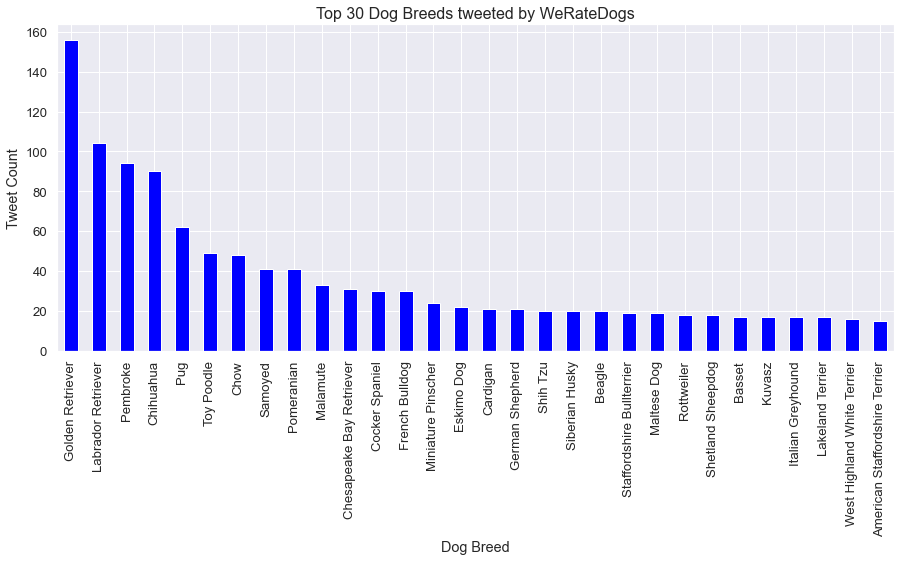

In [106]:
# Plot the response
plt.figure(figsize=(15,6))
response.plot(kind='bar', color=['blue'])
plt.title('Top 30 Dog Breeds tweeted by WeRateDogs', fontsize=16)
plt.xlabel('Dog Breed')
plt.ylabel('Tweet Count');

> **Conclusion :**
> - Noticable top breeds being tweeted are, **Golden retriver, Labrador Retriever, Pembroke, Chihuahua, Pug, Toy Poodle and Chow**
> - Every other breeds gradually decreases in count

<a id='rq2'></a>
### Research Question 2 : Which breed of dogs got the highest rating on average?

> **Process :**
> - Check for the **outliers**
> - If present, filter it
> - Group by `breed` aggregating the sum
> - Calculate **average rating** for each filtered breed

In [107]:
# Total number of tweets of predicted breed
df_breed.shape[0]

1659

In [108]:
# Total number of predicted breeds
df_breed.breed.nunique()

113

In [109]:
# Let's check the lowest tweet count for each breed
df_breed.groupby('breed').count().rating.sort_values(ascending=True)

breed
Clumber                   1
Japanese Spaniel          1
Bouvier Des Flandres      1
Silky Terrier             1
Standard Schnauzer        1
                       ... 
Pug                      62
Chihuahua                90
Pembroke                 94
Labrador Retriever      104
Golden Retriever        156
Name: rating, Length: 113, dtype: int64

> - There are **1659** tweets for **113 unique breeds** in our dataset.
> - There are many outliers, having very low tweet count

In [110]:
# Set a boundary, where each breed should have atleast that number of tweets
boundary = df_breed.shape[0]/df_breed.breed.nunique()
boundary

14.68141592920354

In [111]:
# Filter the breeds based on boundary
filter_breed = df_breed.groupby('breed').count()
filter_breed = filter_breed[filter_breed.rating >= boundary]
filter_breed.tweet_id.unique()

array([ 15,  17,  20,  21,  31,  90,  48,  30,  22, 156, 104,  33,  19,
        24,  94,  41,  62,  18,  49,  16], dtype=int64)

In [112]:
# Calculate the average rating for breeds having tweet count more than or equal to boundary
response  = pd.DataFrame((df_breed.groupby('breed').sum() / filter_breed).rating.dropna().sort_values(ascending=False)).reset_index()
response.tail()

,breed,rating
26,Beagle,1.015000
27,American Staffordshire Terrier,1.013333
28,Miniature Pinscher,1.004167
29,Italian Greyhound,1.000000
30,Maltese Dog,0.973684


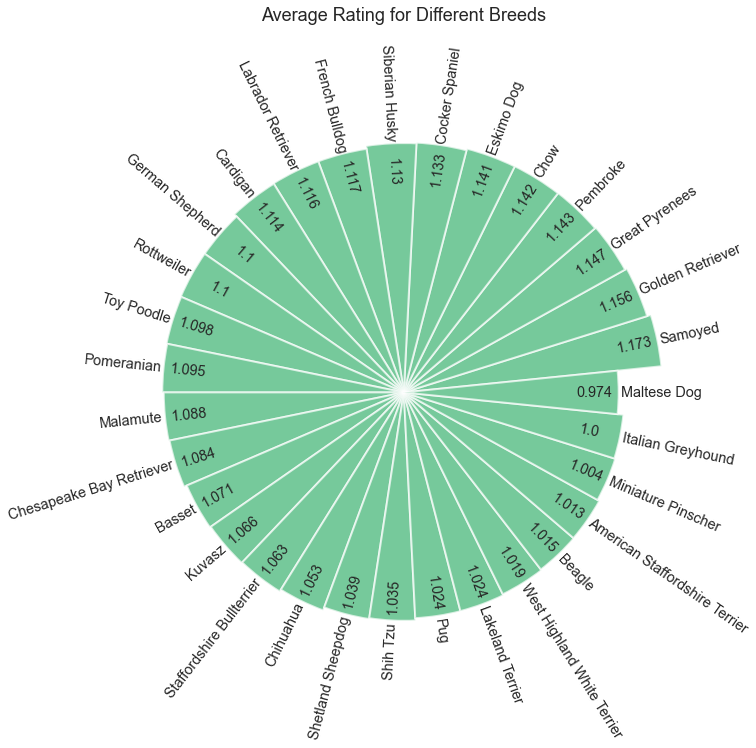

In [113]:
# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')
plt.title('Average Rating for Different Breeds', pad=100, fontsize=18)

# Constants = parameters controling the plot layout:
upperLimit = 5
lowerLimit = 0
labelPadding = 0.01
ratingPadding = 0.19

# Compute max and min in the dataset
max = response['rating'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * response.rating + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(response.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(response.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="mediumseagreen",
    alpha=0.7
)

# Add labels
for bar, angle, height, label, rat in zip(bars,angles, heights, response['breed'], response['rating']):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(        
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
    ax.text(            
        x=angle, 
        y=lowerLimit + bar.get_height() - ratingPadding, 
        s=str(round(rat,3)), 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

> **Conclusion :**
> - Noticable top 5 rated breeds are, **Samoyed, Golden Retriever, Great Pyrenees, Pembroke, and Chow** in order

<a id='rq3'></a>
### Research Question 3 : Which breed of dogs got the highest retweet and favorite counts on average?

> **Process :**
> - Use already filtered data, removing outliers
> - Group by `breed` aggregating the sum
> - Calculate **average retweet count & favorite count** for each filtered breed

In [114]:
# Filtered breeds based on boundary
filter_breed.sample(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,hashtag,jpg_url,confidence,stage,rating
breed,,,,,,,,,,,,,,,
Chow,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48


In [115]:
# Calculate the average retweet_count for breeds having tweet count more than or equal to boundary
res_retweet = round((df_breed.groupby('breed').sum() / filter_breed).retweet_count.dropna().sort_values(ascending=False) , 0)
res_retweet.head()

breed
French Bulldog    4585.0
Cocker Spaniel    4123.0
Eskimo Dog        4039.0
Samoyed           3956.0
Great Pyrenees    3753.0
Name: retweet_count, dtype: float64

In [116]:
# Calculate the average favorite_count for breeds having tweet count more than or equal to boundary
res_favorite = round((df_breed.groupby('breed').sum() / filter_breed).favorite_count.dropna().sort_values(ascending=False) , 0)
res_favorite.head()

breed
French Bulldog    18083.0
Cocker Spaniel    12135.0
Samoyed           12130.0
Eskimo Dog        11420.0
Cardigan          11290.0
Name: favorite_count, dtype: float64

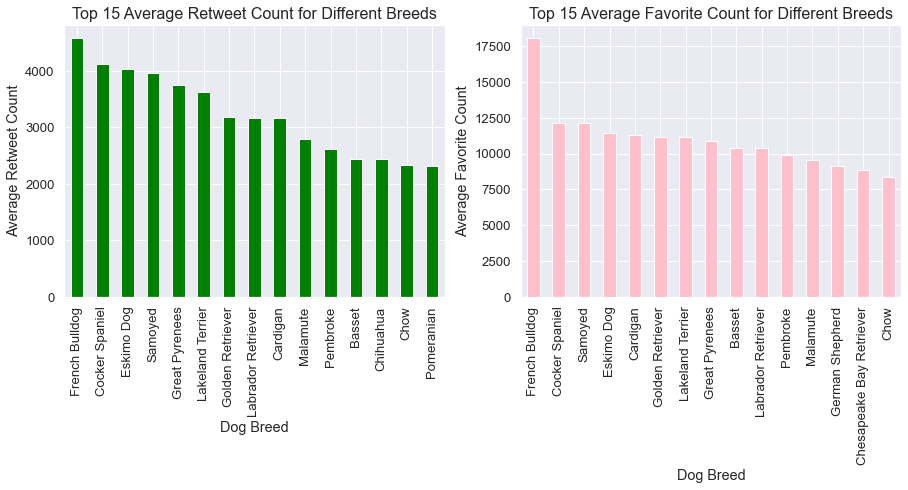

In [117]:
# Plot the top 15 response for retweet
plt.subplot(1,2,1)
res_retweet.nlargest(15).plot(kind='bar', color=['green'], figsize=(15,5))
plt.title('Top 15 Average Retweet Count for Different Breeds', fontsize=16)
plt.xlabel('Dog Breed')
plt.ylabel('Average Retweet Count');

# Plot the top 15 response for favorite
plt.subplot(1,2,2)
res_favorite.nlargest(15).plot(kind='bar', color=['pink'], figsize=(15,5))
plt.title('Top 15 Average Favorite Count for Different Breeds', fontsize=16)
plt.xlabel('Dog Breed')
plt.ylabel('Average Favorite Count');

> **Conclusion :**
> - Noticable top breed being retweeted and favored is, **French Bulldog**

<a id='rq4'></a>
### Research Question 4 : Which stage of dogs got the highest rating, retweet and favorite counts on average?

> **Process :**
> - Consider only the observations classified for stage
> - Check for the outliers. If present, filter it
> - Group by `stage` aggregating the sum
> - Calculate average rating, retweet and favorite counts for each filtered stage

In [118]:
# Consider only the observations classified for stage
df_stage = df.query('stage != "None"')

In [119]:
# Total number of tweets having stage value
df_stage.shape[0]

302

In [120]:
# Number of Unique stage
df_stage.stage.nunique()

6

In [121]:
# Check for outliers
df_stage.groupby('stage').count().tweet_id

stage
doggo             64
doggo,floofer      1
doggo,pupper       4
floofer            7
pupper           203
puppo             23
Name: tweet_id, dtype: int64

> - There are **302** tweets for **6 unique stages** in our dataset.
> - There are **three** outliers, having very low tweet count

In [122]:
# Set a boundary, where each stage should have atleast 10 tweets
boundary = 10

In [123]:
# Filter the breeds based on boundary
filter_stage = df_stage.groupby('stage').count()
filter_stage = filter_stage[filter_stage.tweet_id >= boundary]
filter_stage.tweet_id

stage
doggo      64
pupper    203
puppo      23
Name: tweet_id, dtype: int64

In [124]:
# Calculate the average rating, retweet count and favorite count for stages having tweet count more than or equal to boundary
# sort by rating
response  = (df_stage.groupby('stage').sum() / filter_stage)[['rating','retweet_count','favorite_count']].dropna()
response = pd.DataFrame(response.sort_values(by='rating'))
response

,rating,retweet_count,favorite_count
stage,,,
pupper,1.065650,2010.857143,6486.655172
doggo,1.173437,6075.531250,17784.687500
puppo,1.204348,6027.217391,21182.304348


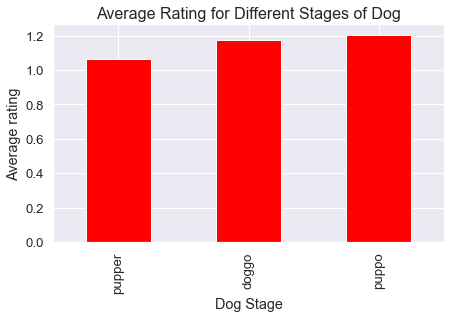

In [125]:
# Plot the response for average rating
response.rating.plot(kind='bar', color=['red'], figsize=(7,4))
plt.title('Average Rating for Different Stages of Dog', fontsize=16)
plt.xlabel('Dog Stage')
plt.ylabel('Average rating'); 

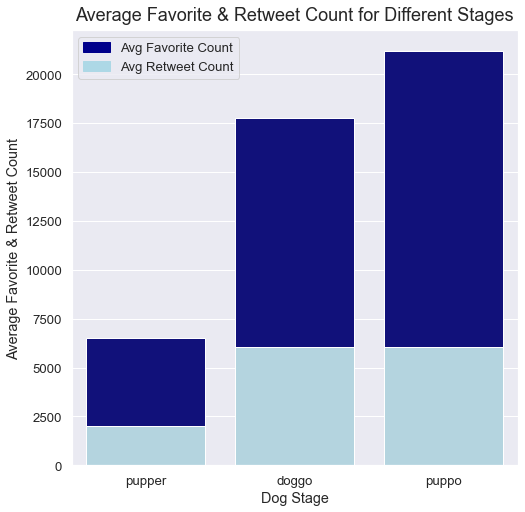

In [126]:
# set the figure size
plt.figure(figsize=(8, 8))

# bar chart 1 -> top bars (group of favorite_count)
bar1 = sns.barplot(x=response.index,  y="favorite_count", data=response, color='darkblue')

# bar chart 2 -> bottom bars (group of retweet_count)
bar2 = sns.barplot(x=response.index, y="retweet_count", data=response, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Avg Favorite Count')
bottom_bar = mpatches.Patch(color='lightblue', label='Avg Retweet Count')
plt.legend(handles=[top_bar, bottom_bar])

# add labels
plt.title('Average Favorite & Retweet Count for Different Stages', fontsize=18, pad=10)
plt.xlabel('Dog Stage')
plt.ylabel('Average Favorite & Retweet Count');

> **Conclusion :**
> - Most **rated & favorited** stage of dog is **puppo**
> - Most **retweeted** stage of dog is **doggo**

<a id='rq5'></a>
### Research Question 5 : Does the hashtags included impact retweet and favorite counts on average?

> **Process :**
> - Create encoded hashtag column, 1 = if hashtag is not 'None', else 0
> - Group by `is_hashtag` aggregating the mean

In [127]:
# Unique hashtags
df.hashtag.unique()

array(['None', 'BarkWeek', 'Canada150', 'PrideMonthPuppo', 'PrideMonth',
       'dogsatpollingstations', 'ScienceMarch', 'K9VeteransDay',
       'WKCDogShow', 'BellLetsTalk', 'WomensMarch', 'FinalFur',
       'notallpuppers', 'NoDaysOff'], dtype=object)

In [128]:
# Create encoded hashtag column
# Value, 1 = if hashtag is not 'None', else 0
df['is_hashtag'] = df.hashtag.apply(lambda x : 1 if (x != 'None') else 0)

In [129]:
# Counts of hashtag presence or not
df.is_hashtag.value_counts()

0    1942
1      22
Name: is_hashtag, dtype: int64

In [130]:
# Group by is_hashtag
response = df.groupby('is_hashtag').mean()[['retweet_count','favorite_count']].transpose()
response

is_hashtag,0,1
retweet_count,2309.072091,6229.681818
favorite_count,7848.251802,22433.454545


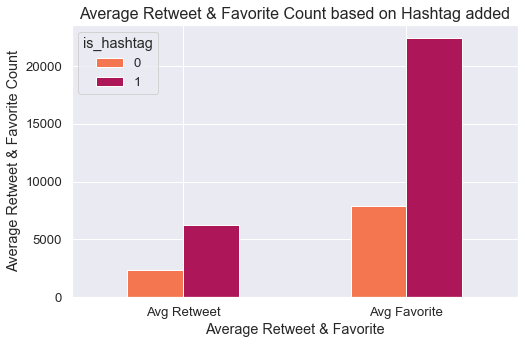

In [131]:
# Plot the response
colors = [sns.color_palette('rocket')[4], sns.color_palette('rocket')[2]]
response.plot(kind='bar', color=colors, figsize=(8,5))
plt.title('Average Retweet & Favorite Count based on Hashtag added', fontsize=16)
plt.xlabel('Average Retweet & Favorite')
plt.xticks(range(2), labels = ['Avg Retweet','Avg Favorite'],rotation=0)
plt.ylabel('Average Retweet & Favorite Count');

> **Conclusion :**
> - Adding **hashtags** has a greater impact in **retweet count** & **favorite count** on average

<a id='rq6'></a>
### Research Question 6 : How does retweet and favorite counts spread based on the tweeted day of the week on average ?

> **Process :**
> - Group by day of the week `timestamp` aggregating the mean

In [132]:
# Starting date & last date in our dataset
df.timestamp.sort_values().min() , df.timestamp.sort_values().max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

In [133]:
# Group by day of the month
df_day = df.groupby(df.timestamp.dt.dayofweek).mean()[['rating','retweet_count','favorite_count']]
df_day

,rating,retweet_count,favorite_count
timestamp,,,
0,1.578221,2223.404908,7581.125767
1,1.060230,2326.347079,8261.041237
2,1.043643,2619.254296,8862.378007
3,1.069224,2083.104693,7286.314079
4,1.068325,2387.335740,7880.732852
5,1.055242,2583.504032,8346.213710
6,1.206693,2276.574803,7910.811024


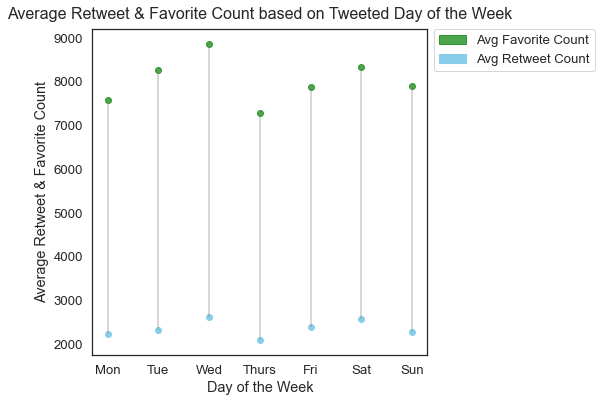

In [134]:
# Set style of plots with seaborn
sns.set(style="white",font_scale=1.2)

# Plot the response 
plt.figure(figsize=(6, 6))
my_range = range(7)

# The plot is made using the vline function
plt.vlines(x=my_range, ymin=df_day['retweet_count'], ymax=df_day['favorite_count'], color='grey', alpha=0.4)
plt.scatter(my_range, df_day['retweet_count'], color='skyblue', alpha=1)
plt.scatter(my_range, df_day['favorite_count'], color='green', alpha=0.7)

plt.title('Average Retweet & Favorite Count based on Tweeted Day of the Week', fontsize=16, pad=10)
plt.xlabel('Day of the Week')

# add legend
top_bar = mpatches.Patch(color='green', label='Avg Favorite Count', alpha=0.7)
bottom_bar = mpatches.Patch(color='skyblue', label='Avg Retweet Count', alpha=1)
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', bbox_to_anchor=(1, 1.02))

# x labels
labels = ['Mon','Tue','Wed','Thurs','Fri','Sat','Sun']
plt.xticks(range(7), labels=labels, rotation=0)
plt.ylabel('Average Retweet & Favorite Count');

> **Conclusion :**
> - **Retweet and Favorite Count on average** increases gradually from **Monday** - **Wednesday**
> - Sudden drop in **Retweet and Favorite Count** in **Mid-Week (Thursday)** on average
> - Gradually increases again before slight drop on **Sunday**

<a id='rq7'></a>
### Research Question 7 : Does the rating impact Retweet and Favorite Count?

> **Process :**
> - Check the correlation between rating, Favorites and Retweets

In [135]:
# Correlation between rating, Retweet and Favorite
cor_rel = df[['rating','retweet_count','favorite_count']].corr()
cor_rel

,rating,retweet_count,favorite_count
rating,1.000000,0.022394,0.021252
retweet_count,0.022394,1.000000,0.928457
favorite_count,0.021252,0.928457,1.000000


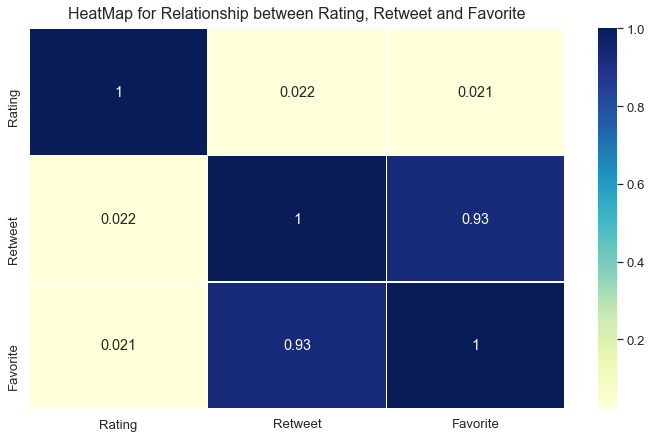

In [136]:
# Heatmap visualisation
plt.figure(figsize=(12,7))
labels = ['Rating','Retweet','Favorite']
sns.heatmap(cor_rel, xticklabels=labels, yticklabels=labels, annot=True, linewidths=.4, cmap="YlGnBu")
plt.title('HeatMap for Relationship between Rating, Retweet and Favorite', fontsize=16, pad=10);

> **Conclusion :**
> - Rating **very less likely** to impact **Retweet and Favorite Count**

<a id='rq8'></a>
### Research Question 8 : Relationship between Retweet and Favorite Count

> **Process :**
> - Check the correlation between Favorites and Retweets

In [137]:
# Correlation between Retweet and Favorite
df[['retweet_count','favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.928457
favorite_count,0.928457,1.000000


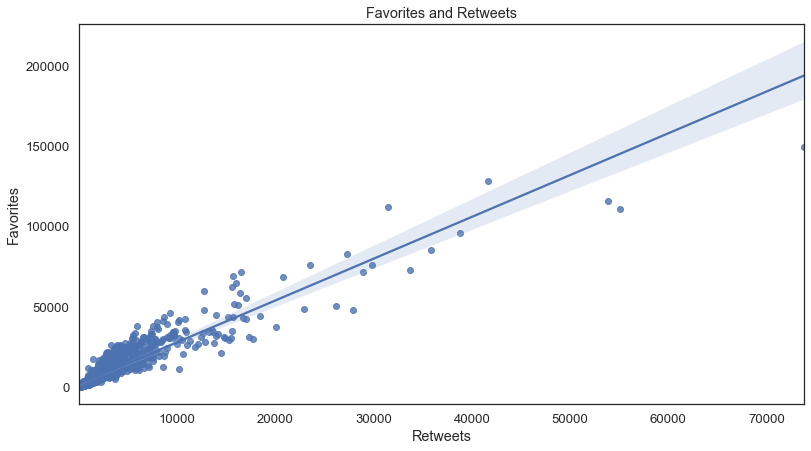

In [138]:
plt.figure(figsize=(13,7))
sns.regplot(x=df.retweet_count, y=df.favorite_count)
plt.title("Favorites and Retweets")
plt.xlabel('Retweets')
plt.ylabel('Favorites');

> **Conclusion :**
> -  **Retweets and Favorites** are **highly** correlated

<a id="conclusions"></a>
## Conclusions

Data Wrangling Process carried out and the below analyses are based on the wrangled data,

> - Noticable top breeds being tweeted are, **Golden retriver, Labrador Retriever, Pembroke, Chihuahua, Pug, Toy Poodle and Chow**
> - Every other breeds gradually decreases in count
> - Noticable top 5 rated breeds are, **Samoyed, Golden Retriever, Great Pyrenees, Pembroke, and Chow** in order
> - Noticable top breed being retweeted and favored is, **French Bulldog**
> - Most **rated & favorited** stage of dog is **puppo**
> - Most **retweeted** stage of dog is **doggo**
> - Adding **hashtags** has a greater impact in **retweet count** & **favorite count** on average
> - **Retweet and Favorite Count on average** increases gradually from **Monday** - **Wednesday**
> - Sudden drop in **Retweet and Favorite Count** in **Mid-Week (Thursday)** on average
> - Gradually increases again before slight drop on **Sunday**
> - Rating **very less likely** to impact **Retweet and Favorite Count**
> -  **Retweets and Favorites** are **highly** correlated

**<i>Reference websites,</i>**
- [Numpy](https://numpy.org/doc/stable/contents.html)
- [Pandas](https://pandas.pydata.org)
- [Assign multiple values to multiple columns](https://stackoverflow.com/questions/18882501/assigning-multiple-column-values-in-a-single-row-of-pandas-dataframe-in-one-lin)
- [Regex](https://www.programiz.com/python-programming/regex)
- [Convert set to comma separated string](https://www.kite.com/python/answers/how-to-make-a-list-into-a-comma-separated-string-in-python#:~:text=Call%20str.,into%20a%20comma%2Dseparated%20string.&text=If%20the%20list%20contains%20non,element%20to%20a%20string%20first.)
- [Capitalize each word in a sentence](https://stackoverflow.com/questions/1549641/how-can-i-capitalize-the-first-letter-of-each-word-in-a-string)